In [3]:
import os
import sys
import numpy as np
import tensorflow as tf
import random
import math
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Note: CUSTOM LOCATION FOR LOCAL DATA ON MY MACBOOK!!!
TRAIN_PATH = '/Users/brandonpippin/Documents/Kaggle/DataBowl2018/stage1_train/'
TEST_PATH = '/Users/brandonpippin/Documents/Kaggle/DataBowl2018/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
# Get and resize train images and masks
# Note: CUSTOM LOCATION FOR LOCAL DATA ON MY MACBOOK!!!
images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
labels = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    images[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    labels[n] = mask

X_train = images
Y_train = labels

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:29<00:00,  7.45it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 79.86it/s]

Done!


In [7]:
def shuffle():
    global images, labels
    p = np.random.permutation(len(X_train))
    images = X_train[p]
    labels = Y_train[p]

In [8]:
#what does this do?

def next_batch(batch_s, iters):
    if(iters == 0):
        shuffle()
    count = batch_s * iters
    return images[count:(count + batch_s)], labels[count:(count + batch_s)]

In [9]:
#what does this do?

def deconv2d(input_tensor, filter_size, output_size, out_channels, in_channels, name, strides = [1, 1, 1, 1]):
    dyn_input_shape = tf.shape(input_tensor)
    batch_size = dyn_input_shape[0]
    out_shape = tf.stack([batch_size, output_size, output_size, out_channels])
    filter_shape = [filter_size, filter_size, out_channels, in_channels]
    w = tf.get_variable(name=name, shape=filter_shape)
    h1 = tf.nn.conv2d_transpose(input_tensor, w, out_shape, strides, padding='VALID')
    return h1

In [10]:
#what does this do?

def conv2d(input_tensor, depth, kernel, name, strides=(1, 1), padding="VALID"):
    return tf.layers.conv2d(input_tensor, filters=depth, kernel_size=kernel, strides=strides, padding=padding, activation=tf.nn.relu, name=name)


In [11]:
X = tf.placeholder(tf.float32, [None, 128, 128, 3])
Y_ = tf.placeholder(tf.float32, [None, 128, 128, 1])
lr = tf.placeholder(tf.float32)


In [12]:
#Pippin: This looks like 

net = conv2d(X, 33, 1, "Y0")

net = conv2d(net, 33, 2, "Y1", strides=(2, 2))

net = conv2d(net, 33, 2, "Y2", strides=(2, 2))


net = deconv2d(net, 1, 32, 33, 33, "Y2_deconv")
net = tf.nn.relu(net)

net = deconv2d(net, 2, 64, 33, 33, "Y1_deconv", strides=[1, 2, 2, 1])
net = tf.nn.relu(net)

net = deconv2d(net, 2, 128, 27, 33, "Y0_deconv", strides=[1, 2, 2, 1])
net = tf.nn.relu(net)


logits = deconv2d(net, 1, 128, 1, 27, "logits_deconv")

In [13]:
loss = tf.losses.sigmoid_cross_entropy(Y_, logits)
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_count = 0
display_count = 1
for i in range(10000):
    # training on batches of 10 images with 10 mask images
    if(batch_count > 67):
        batch_count = 0    

    batch_X, batch_Y = next_batch(10, batch_count)

    batch_count += 1

    feed_dict = {X: batch_X, Y_: batch_Y, lr: 0.0005}
    loss_value, _ = sess.run([loss, optimizer], feed_dict=feed_dict)

    if(i % 500 == 0):
        print(str(display_count) + " training loss:", str(loss_value))
        display_count +=1
        
print("Done!")

('1 training loss:', '0.829852')
('2 training loss:', '0.138671')
('3 training loss:', '0.175985')
('4 training loss:', '0.128051')
('5 training loss:', '0.122027')
('6 training loss:', '0.131384')
('7 training loss:', '0.129955')
('8 training loss:', '0.168001')
('9 training loss:', '0.110291')
('10 training loss:', '0.117861')
('11 training loss:', '0.0901773')
('12 training loss:', '0.0984052')
('13 training loss:', '0.0859465')
('14 training loss:', '0.112286')
('15 training loss:', '0.133118')
('16 training loss:', '0.0910944')
('17 training loss:', '0.0595742')
('18 training loss:', '0.084775')
('19 training loss:', '0.105765')
('20 training loss:', '0.134644')
Done!


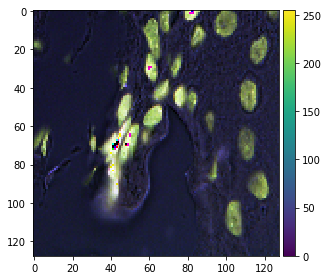

In [14]:
ix = 38 #random.randint(0, 64) #len(X_test) - 1 = 64
test_image = X_test[ix].astype(float)
imshow(test_image)
plt.show()

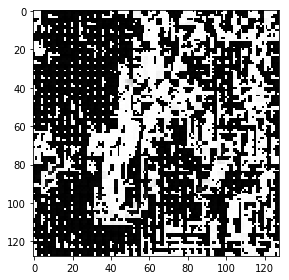

In [15]:
#print(ix)
test_image = np.reshape(test_image, [-1, 128 , 128, 3])
test_data = {X:test_image}

test_mask = sess.run([logits],feed_dict=test_data)
test_mask = np.reshape(test_mask, [128 , 128, 1]).astype(np.uint8)
imshow(test_mask.squeeze(), cmap="gray_r")
plt.show()